### case study 2 ex 11

In [1]:
# Case Study-2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing,linear_model,metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from warnings import filterwarnings
filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akanksh_02\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akanksh_02\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# loading the dataset containing tweets of racist or sexist sentiments
train_set = pd.read_csv("nlp2train.csv")
test_set = pd.read_csv("nlp2test.csv")
print(train_set.head())
print("-------------------------------------------------")
print(test_set.head())

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
-------------------------------------------------
      id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...


In [4]:
print("Train_set shape: {} \n Test_set shape: {}".format(train_set.shape,test_set.shape))
print("Total no. of duplicates in trainset : ",train_set.duplicated().sum())

Train_set shape: (31962, 3) 
 Test_set shape: (17197, 2)
Total no. of duplicates in trainset :  0


In [5]:
# target-label value_counts using groupby
train_set.groupby("label").count().style.background_gradient(cmap = "summer")

,id,tweet
label,,
0,29720,29720
1,2242,2242


In [6]:
import re

# Cleaning Raw tweets
def clean_text(text):
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    #remove web address ? Means matching anything to its left \S all non white space characters
    text = re.sub('http[s]?://\S+', '', text)
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    #Convert to lowercase to maintain consistency
    text = text.lower()
    #remove double spaces
    text = re.sub('\s+', ' ',text)
    return text
train_set['tweet'] = train_set['tweet'].apply(lambda x: clean_text(x))
test_set['tweet'] = test_set['tweet'].apply(lambda x: clean_text(x))

# Removing stopwords
sw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

# Finally,Stemming the words
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(train_set.head())
print(test_set.head())

   id  label                                              tweet
0   1      0  father dysfunctional selfish drag kid dysfunct...
1   2      0  thanks lyft credit can't use cause offer wheel...
2   3      0                                     bihday majesty
3   4      0                        model love u take u time ur
4   5      0                      factsguide society motivation
      id                                              tweet
0  31963  studiolife aislife requires passion dedication...
1  31964  white supremacist want everyone see new bird m...
2  31965   safe way heal acne altwaystoheal healthy healing
3  31966  hp cursed child book reservation already yes h...
4  31967  rd bihday amazing hilarious nephew eli ahmir u...


In [7]:
# removing 'id'-column because it is unnecessary for model-training
train_set = train_set.drop('id', axis=1)
test_set = test_set.drop('id', axis=1)

# splitting train_set into train,test data
X = train_set['tweet']
y = train_set['label']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=11)

In [8]:
# Vectorization using CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
x_train_count = vectorizer.transform(x_train)
x_test_count = vectorizer.transform(x_test)
x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
# Vectorization using TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vectorizer.fit(x_train)
x_train_tf_idf = tf_idf_vectorizer.transform(x_train)
x_test_tf_idf = tf_idf_vectorizer.transform(x_test)
x_train_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
# model training and Cross-validation using count_vectorizer-data
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(x_train_count, y_train)
acc = model_selection.cross_val_score(log_model, x_test_count, y_test, cv=20)     # cv=20 indicates it generates 20-models on test_data
print(acc)

[0.95625    0.940625   0.9375     0.946875   0.94375    0.9625
 0.94375    0.94375    0.9375     0.953125   0.940625   0.95625
 0.953125   0.95297806 0.94357367 0.94670846 0.94357367 0.94357367
 0.95611285 0.95611285]


In [11]:
acc_mean = np.mean(acc)
print("Logistic Regression model with count-vectors method")
print("Accuracy : ",(acc_mean)*100)

Logistic Regression model with count-vectors method
Accuracy :  94.79129114420066


In [12]:
# model training and Cross-validation using Tfidf_vectorizer-data
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(x_train_tf_idf, y_train)
acc = model_selection.cross_val_score(log_model, x_test_tf_idf, y_test, cv=20)     # cv=20 indicates it generates 20-models on test_data
print(acc)

[0.928125   0.93125    0.925      0.925      0.9375     0.93125
 0.928125   0.928125   0.928125   0.940625   0.928125   0.928125
 0.934375   0.93103448 0.93416928 0.92789969 0.94043887 0.92789969
 0.92789969 0.93730408]


In [13]:
acc_mean = np.mean(acc)
print("Logistic Regression model with Tfidf-vectors method")
print("Accuracy : ",(acc_mean)*100)

Logistic Regression model with Tfidf-vectors method
Accuracy :  93.10197884012538


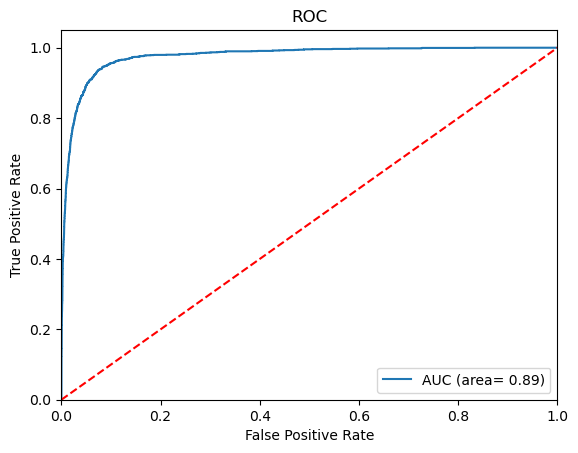

In [14]:
# ROC-curve
X = x_train_count.astype('float64')
y = y_train
logistic_roc_auc = roc_auc_score(y, log_model.predict(X))
fpr, tpr, thresholds = roc_curve(y, log_model.predict_proba(X)[:,1])

plt.figure()
plt.plot(fpr, tpr,label='AUC (area= %0.2f)' % logistic_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [15]:
# testing hate_speech detection
print(x_train[0])
new_tweet = x_train[0]
new_tweet_features = vectorizer.transform([new_tweet])
log_model.predict(new_tweet_features)

father dysfunctional selfish drag kid dysfunction run


array([0], dtype=int64)

In [16]:
print(x_train[13])
new_tweet = x_train[13]
new_tweet_features = vectorizer.transform([new_tweet])
log_model.predict(new_tweet_features)

cnn call michigan middle school 'build wall' chant '' tcot


array([1], dtype=int64)

In [17]:
train_set.head(20)

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit can't use cause offer wheel...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation
5,0,huge fan fare big talking leave chaos pay disp...
6,0,camping tomorrow danny
7,0,next school year year exam can't think school ...
8,0,love land allin cavs champion cleveland clevel...
9,0,welcome i'm gr


In [18]:
####### or take this code for google drive
## check hastags

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')
from warnings import filterwarnings
filterwarnings('ignore')

print("\nLIBRARIES WERE SUCCESSFULLY IMPORTED...")

# Load datasets
train_set = pd.read_csv("nlp2train.csv", encoding="utf-8", engine="python", header=0)
test_set = pd.read_csv("nlp2test.csv", encoding="utf-8", engine="python", header=0)

print("\nDATASETS WERE SUCCESSFULLY LOADED...")
display(train_set.head(5))
display(test_set.head(5))



LIBRARIES WERE SUCCESSFULLY IMPORTED...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akanksh_02\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akanksh_02\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



DATASETS WERE SUCCESSFULLY LOADED...


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


Train set shape: (31962, 3) and test set shape: (17197, 2)
Totally there are 0 duplicated values in train_set


,id,tweet
label,,
0,29720,29720
1,2242,2242



CONVERTED SUCCESSFULLY...

DELETED SUCCESSFULLY...

STOPWORDS DELETED SUCCESSFULLY...

'ID' COLUMNS DROPPED SUCCESSFULLY...

DIVIDED SUCCESSFULLY...
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


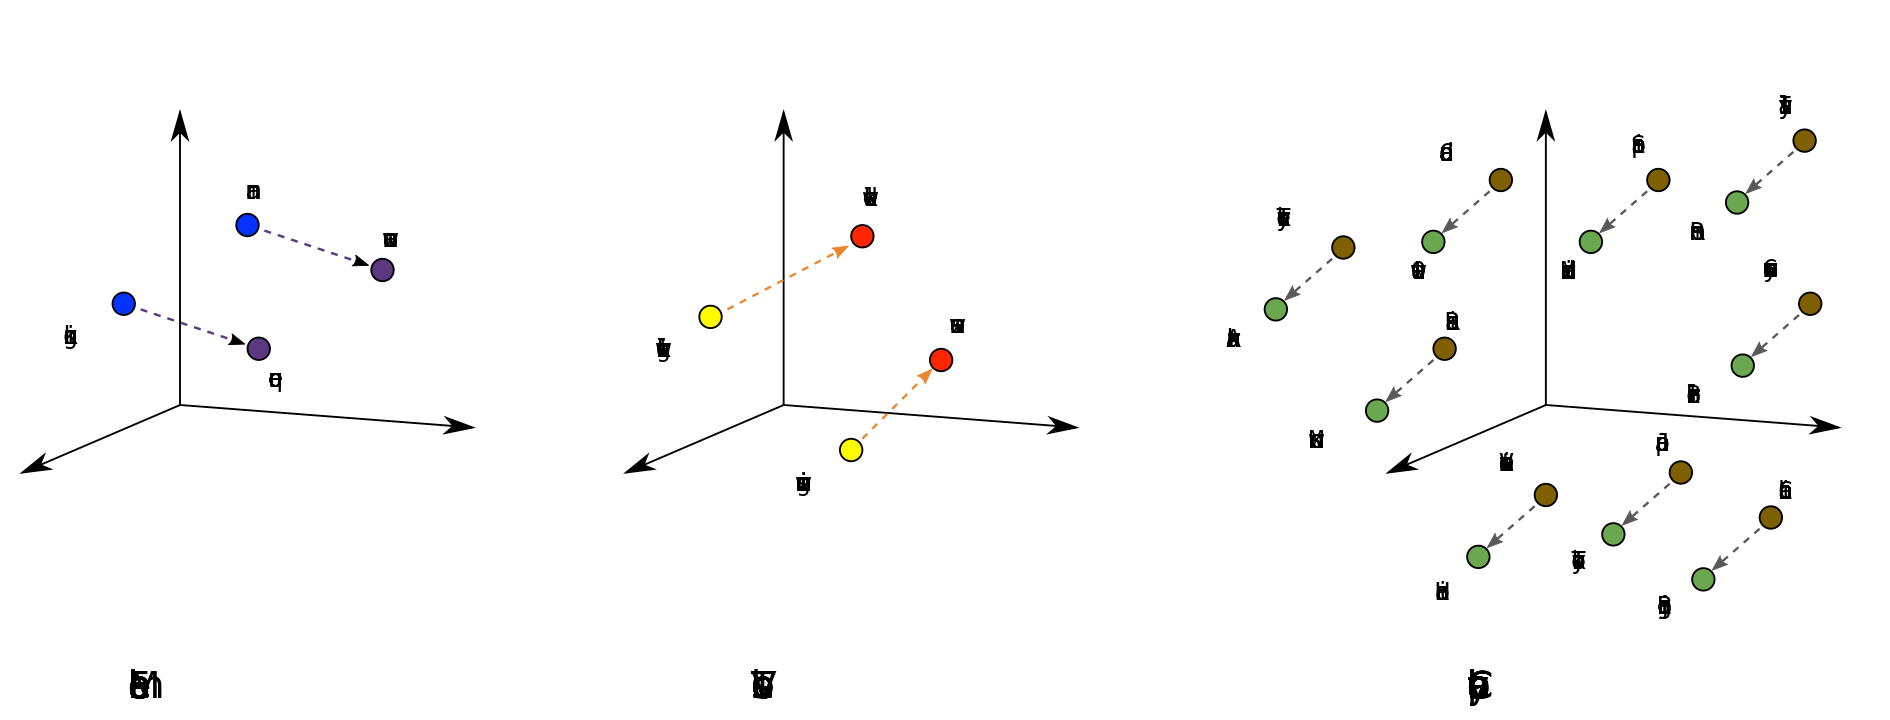

In [20]:

print("Train set shape: {} and test set shape: {}".format(train_set.shape, test_set.shape))
print("Totally there are {} duplicated values in train_set".format(train_set.duplicated().sum()))

# Display the count of labels
display(train_set.groupby("label").count().style.background_gradient(cmap="summer"))

# Convert tweets to lowercase
train_set["tweet"] = train_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set["tweet"] = test_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
print("\nCONVERTED SUCCESSFULLY...")

# Remove punctuation
train_set["tweet"] = train_set["tweet"].str.replace('[^\w\s]', '', regex=True)
test_set["tweet"] = test_set["tweet"].str.replace('[^\w\s]', '', regex=True)
print("\nDELETED SUCCESSFULLY...")

# Remove stopwords
sw = set(stopwords.words("english"))
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
print("\nSTOPWORDS DELETED SUCCESSFULLY...")

# Lemmatize words
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Drop 'id' column if it exists
if 'id' in train_set.columns:
    train_set = train_set.drop("id", axis=1)
if 'id' in test_set.columns:
    test_set = test_set.drop("id", axis=1)
print("\n'ID' COLUMNS DROPPED SUCCESSFULLY...")

# Split the data into train and test sets
x = train_set["tweet"]
y = train_set["label"]
train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size=0.20, shuffle=True, random_state=11)
print("\nDIVIDED SUCCESSFULLY...")

# Vectorizing the text data
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)
print(x_train_count.toarray())

######
from IPython.display import Image, display
# Display the image
display(Image(filename='embeddings.png'))
# Install the IPython library if not already installed
!pip install ipython

[0.95625    0.946875   0.946875   0.95       0.95       0.953125
 0.946875   0.946875   0.940625   0.965625   0.9375     0.953125
 0.94375    0.94984326 0.94357367 0.94670846 0.94670846 0.94357367
 0.94984326 0.95297806]

Logistic regressionmodelwith 'count-vectors' method
Accuracy ratio:  0.9485364420062699
0.9307072884012537

Logistic regressionmodelwith 'count-vectors' method
Accuracy ratio:  0.9307072884012537


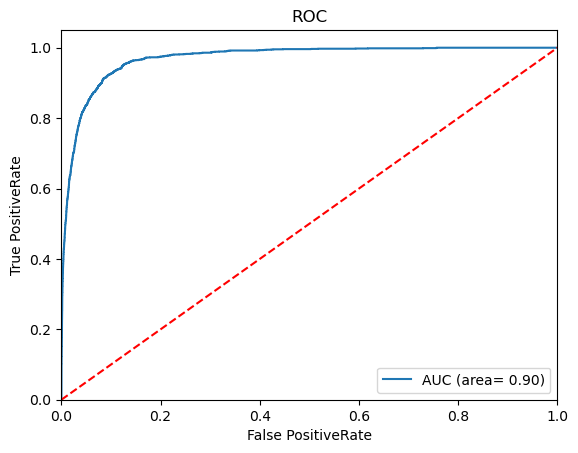

user father dysfunctional selfish drag kid dysfunction run


array([0], dtype=int64)

In [21]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)
x_train_tf_idf_word.toarray()
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(log_model, x_test_count, test_y, cv = 20)
print(accuracy)
mean = np.mean(accuracy)
print("\nLogistic regressionmodelwith 'count-vectors' method")
print("Accuracy ratio: ", mean)
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
x_test_tf_idf_word,
test_y,
cv = 20).mean()
print(accuracy)
mean = np.mean(accuracy)
print("\nLogistic regressionmodelwith 'count-vectors' method")
print("Accuracy ratio: ", mean)
y = train_y
X = x_train_count.astype("float64")
logit_roc_auc = roc_auc_score(y, log_model.predict(X))
fpr, tpr,thresholds = roc_curve(y, log_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr,label='AUC (area= %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.xlabel('False PositiveRate')
plt.ylabel('True PositiveRate')
plt.title('ROC')
plt.show()
print(train_x[0])
new_tweet = train_x[0]
new_tweet_features = vectorizer.transform([new_tweet])
log_model.predict(new_tweet_features)